# Code written exclusively to rebin hits

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append("/gluster/data/next/notebooks/john_books/sanity_booklet/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from IC.invisible_cities.cities.components import track_blob_info_creator_extractor
from IC.invisible_cities.io.hits_io        import load_hits
from IC.invisible_cities.io.hits_io        import hits_from_df
from IC.invisible_cities.core              import system_of_units as units
from IC.invisible_cities.types.symbols     import HitEnergy
from IC.invisible_cities.evm.event_model   import HitCollection
from IC.invisible_cities.evm.event_model   import Cluster
from IC.invisible_cities.evm.event_model   import Hit
from IC.invisible_cities.types.ic_types    import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from tqdm import tqdm

import HE_calibration.functions_HE as func

# load some hits in

In [2]:
RUN_NUMBER = 15107
TIMESTAMP  = 140425

In [3]:
folder_path = f'/gluster/data/next/files/TOPOLOGY_John/N100_data/{RUN_NUMBER}/sophronia_rebin/trigger_2/ldc1/'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
hits = load_dst(f'{folder_path}{file_names[2]}', 'RECO', 'Events')

In [4]:
display(hits)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1198115,1.742951e+09,0,0.336665,-30.760678,1,212.125,137.075,0.0,0.0,294.902875,5.837002,95.038699,-1.0,0.000257,-1,-1.0
1,1198115,1.742951e+09,0,0.336665,-30.760678,1,335.525,184.225,0.0,0.0,294.902875,5.116071,83.300421,-1.0,0.000237,-1,-1.0
2,1198115,1.742951e+09,0,0.336665,-30.760678,1,427.825,-48.025,0.0,0.0,294.902875,5.626319,91.608346,-1.0,0.000273,-1,-1.0
3,1198115,1.742951e+09,0,0.336665,-30.760678,1,-265.925,-217.075,0.0,0.0,298.258375,6.652004,87.433856,-1.0,0.000244,-1,-1.0
4,1198115,1.742951e+09,0,0.336665,-30.760678,1,-81.325,-278.775,0.0,0.0,298.258375,5.009154,65.840258,-1.0,0.000178,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4184,1198290,1.742951e+09,0,125.760195,139.807329,1,-112.425,-109.725,0.0,0.0,508.463500,6.493578,53.306890,-1.0,0.000144,-1,-1.0
4185,1198290,1.742951e+09,0,125.760195,139.807329,1,227.675,260.475,0.0,0.0,508.463500,6.540303,53.690461,-1.0,0.000155,-1,-1.0
4186,1198290,1.742951e+09,0,125.760195,139.807329,1,351.075,-48.025,0.0,0.0,508.463500,8.236981,67.618781,-1.0,0.000194,-1,-1.0
4187,1198290,1.742951e+09,0,125.760195,139.807329,1,257.775,260.975,0.0,0.0,508.463500,5.069935,41.619961,-1.0,0.000121,-1,-1.0


In [5]:
hits[hits.event == 1198115].Z.diff()

0          NaN
1       0.0000
2       0.0000
3       3.3555
4       0.0000
         ...  
3103    0.0000
3104    0.0000
3105    0.0000
3106    0.0000
3107    0.0000
Name: Z, Length: 3108, dtype: float64

In [5]:

cut_sensors       = beerfun.cut_over_Q   (10, ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated([16.,16.], ['E', 'Ec'])

EVENT 1198115
Total energy 1.19 MeV

Time spent in cut_over_Q: 0.21927618980407715 s
Time spent in drop_isolated: 0.0934152603149414 s


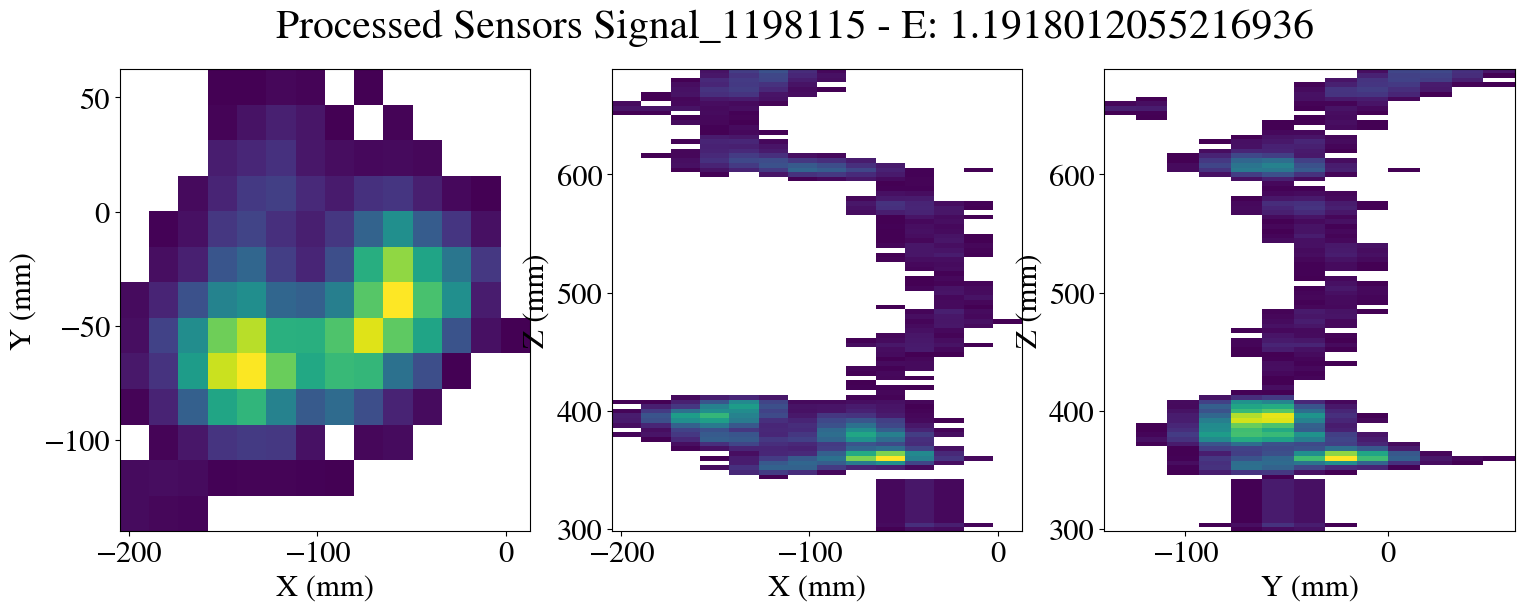

EVENT 1198290
Total energy 0.47 MeV

Time spent in cut_over_Q: 0.030376672744750977 s
Time spent in drop_isolated: 0.032242774963378906 s


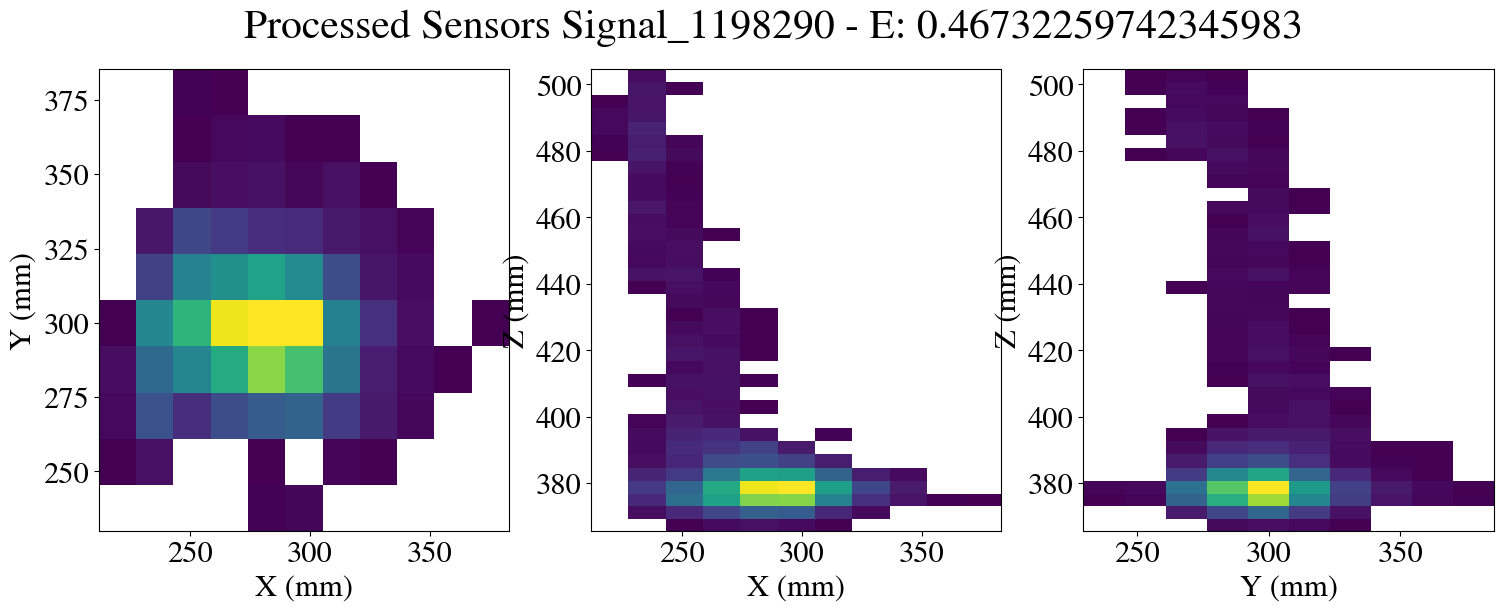

In [6]:
for evts in hits.event.unique():
    func.plotter(hits, evts, cut_sensors=cut_sensors, drop_sensors=drop_sensors)

# NOW REBIN!

In [7]:
hits_drop = hits.copy(deep = True)

In [8]:
import itertools

print(hits_drop.Z.unique() - hits_drop.Z.min())
print(np.diff(hits_drop.Z.unique()))

[  0.         3.3555     6.820625  10.285875  13.337125  44.272125
  47.605875  51.200875  55.168125  59.087     62.9195    66.7785
  70.833625  75.071     78.985375  82.877     86.917125  91.025125
  94.9465    98.837125 102.919875 106.856625 110.625125 114.518125
 118.746875 122.981625 126.94375  131.009125 134.862125 138.983
 142.8635   146.921375 151.042    155.105625 158.8725   162.844125
 166.81775  170.889    175.08675  178.86425  182.929625 186.941375
 190.887375 194.997875 198.98125  202.7745   206.803625 210.861625
 215.10075  219.05375  223.1615   227.07925  231.001625 234.933
 238.892625 242.8335   246.86725  250.97075  254.960125 258.87575
 263.114    267.091    271.03375  274.90675  278.73025  282.6085
 286.6585   290.92875  295.297875 299.28425  303.133625 306.926625
 310.86325  314.75275  318.733625 322.921375 326.926375 330.76875
 334.773625 338.78975  342.927875 347.238875 351.091625 355.104625
 358.9805   362.914375 367.081    370.98075  374.874625 379.003
 382.99275

In [9]:
rebin_data = ((hits_drop.Z) // 4) * 4
print(max((hits_drop.Z - rebin_data).unique()))


3.5160000000000196


In [10]:
for (evts, npeak), df in hits_drop.groupby(['event', 'npeak']):
    print(evts)
    print(npeak)
    display(df)
    
    print(df.Z.unique())
    print(f'Z differences:\n{np.diff(hits_drop.Z.unique())}')

1198115
0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1198115,1.742951e+09,0,0.336665,-30.760678,1,212.125,137.075,0.0,0.0,294.902875,5.837002,95.038699,-1.0,0.000257,-1,-1.0
1,1198115,1.742951e+09,0,0.336665,-30.760678,1,335.525,184.225,0.0,0.0,294.902875,5.116071,83.300421,-1.0,0.000237,-1,-1.0
2,1198115,1.742951e+09,0,0.336665,-30.760678,1,427.825,-48.025,0.0,0.0,294.902875,5.626319,91.608346,-1.0,0.000273,-1,-1.0
3,1198115,1.742951e+09,0,0.336665,-30.760678,1,-265.925,-217.075,0.0,0.0,298.258375,6.652004,87.433856,-1.0,0.000244,-1,-1.0
4,1198115,1.742951e+09,0,0.336665,-30.760678,1,-81.325,-278.775,0.0,0.0,298.258375,5.009154,65.840258,-1.0,0.000178,-1,-1.0
5,1198115,1.742951e+09,0,0.336665,-30.760678,1,-50.225,-63.075,0.0,0.0,298.258375,6.425230,84.453139,-1.0,0.000220,-1,-1.0
6,1198115,1.742951e+09,0,0.336665,-30.760678,1,-50.225,-31.975,0.0,0.0,298.258375,11.497557,151.123734,-1.0,0.000394,-1,-1.0
7,1198115,1.742951e+09,0,0.336665,-30.760678,1,-34.675,-63.075,0.0,0.0,298.258375,10.540120,138.539200,-1.0,0.000361,-1,-1.0
8,1198115,1.742951e+09,0,0.336665,-30.760678,1,-34.675,-47.525,0.0,0.0,298.258375,15.404048,202.470604,-1.0,0.000526,-1,-1.0
9,1198115,1.742951e+09,0,0.336665,-30.760678,1,-34.675,-31.975,0.0,0.0,298.258375,19.096636,251.005930,-1.0,0.000655,-1,-1.0


[294.902875 298.258375 301.7235   305.18875  308.24    ]
Z differences:
[   3.3555      3.465125    3.46525     3.05125    30.935       3.33375
    3.595       3.96725     3.918875    3.8325      3.859       4.055125
    4.237375    3.914375    3.891625    4.040125    4.108       3.921375
    3.890625    4.08275     3.93675     3.7685      3.893       4.22875
    4.23475     3.962125    4.065375    3.853       4.120875    3.8805
    4.057875    4.120625    4.063625    3.766875    3.971625    3.973625
    4.07125     4.19775     3.7775      4.065375    4.01175     3.946
    4.1105      3.983375    3.79325     4.029125    4.058       4.239125
    3.953       4.10775     3.91775     3.922375    3.931375    3.959625
    3.940875    4.03375     4.1035      3.989375    3.915625    4.23825
    3.977       3.94275     3.873       3.8235      3.87825     4.05
    4.27025     4.369125    3.986375    3.849375    3.793       3.936625
    3.8895      3.980875    4.18775     4.005       3.842375    

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
59,1198115,1.742951e+09,1,-38.066218,-9.255988,1,104.275,291.575,0.0,0.0,339.175000,5.040382,125.138027,-1.0,0.000344,-1,-1.0
60,1198115,1.742951e+09,1,-38.066218,-9.255988,1,-312.575,137.575,0.0,0.0,342.508750,7.763466,252.141871,-1.0,0.000699,-1,-1.0
61,1198115,1.742951e+09,1,-38.066218,-9.255988,1,-126.975,-47.525,0.0,0.0,342.508750,5.693107,184.900737,-1.0,0.000491,-1,-1.0
62,1198115,1.742951e+09,1,-38.066218,-9.255988,1,-112.425,-47.525,0.0,0.0,342.508750,13.017838,422.793371,-1.0,0.001114,-1,-1.0
63,1198115,1.742951e+09,1,-38.066218,-9.255988,1,-96.875,-47.525,0.0,0.0,342.508750,5.498610,178.583890,-1.0,0.000470,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,1198115,1.742951e+09,1,-38.066218,-9.255988,1,88.725,260.475,0.0,0.0,689.004875,7.319262,23.637034,-1.0,0.000067,-1,-1.0
3104,1198115,1.742951e+09,1,-38.066218,-9.255988,1,134.375,-202.025,0.0,0.0,689.004875,5.658264,18.272961,-1.0,0.000051,-1,-1.0
3105,1198115,1.742951e+09,1,-38.066218,-9.255988,1,227.675,75.875,0.0,0.0,689.004875,5.447711,17.592995,-1.0,0.000050,-1,-1.0
3106,1198115,1.742951e+09,1,-38.066218,-9.255988,1,273.325,260.975,0.0,0.0,689.004875,5.016404,16.200120,-1.0,0.000048,-1,-1.0


[339.175    342.50875  346.10375  350.071    353.989875 357.822375
 361.681375 365.7365   369.973875 373.88825  377.779875 381.82
 385.928    389.849375 393.74     397.82275  401.7595   405.528
 409.421    413.64975  417.8845   421.846625 425.912    429.765
 433.885875 437.766375 441.82425  445.944875 450.0085   453.775375
 457.747    461.720625 465.791875 469.989625 473.767125 477.8325
 481.84425  485.79025  489.90075  493.884125 497.677375 501.7065
 505.7645   510.003625 513.956625 518.064375 521.982125 525.9045
 529.835875 533.7955   537.736375 541.770125 545.873625 549.863
 553.778625 558.016875 561.993875 565.936625 569.809625 573.633125
 577.511375 581.561375 585.831625 590.20075  594.187125 598.0365
 601.8295   605.766125 609.655625 613.6365   617.82425  621.82925
 625.671625 629.6765   633.692625 637.83075  642.14175  645.9945
 650.0075   653.883375 657.81725  661.983875 665.883625 669.7775
 673.905875 677.895625 681.7915   685.619625 689.004875]
Z differences:
[   3.3555      

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
3108,1198290,1.742951e+09,0,125.760195,139.807329,1,243.225,91.425,0.0,0.0,362.171625,5.993732,64.701512,-1.0,0.000176,-1,-1.0
3109,1198290,1.742951e+09,0,125.760195,139.807329,1,273.325,307.625,0.0,0.0,362.171625,9.248623,99.837604,-1.0,0.000298,-1,-1.0
3110,1198290,1.742951e+09,0,125.760195,139.807329,1,-482.625,229.875,0.0,0.0,365.569250,5.182848,60.227306,-1.0,NaN,-1,-1.0
3111,1198290,1.742951e+09,0,125.760195,139.807329,1,88.725,-386.625,0.0,0.0,365.569250,6.119411,71.110634,-1.0,0.000206,-1,-1.0
3112,1198290,1.742951e+09,0,125.760195,139.807329,1,73.175,-47.525,0.0,0.0,365.569250,5.808118,67.493252,-1.0,0.000177,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4184,1198290,1.742951e+09,0,125.760195,139.807329,1,-112.425,-109.725,0.0,0.0,508.463500,6.493578,53.306890,-1.0,0.000144,-1,-1.0
4185,1198290,1.742951e+09,0,125.760195,139.807329,1,227.675,260.475,0.0,0.0,508.463500,6.540303,53.690461,-1.0,0.000155,-1,-1.0
4186,1198290,1.742951e+09,0,125.760195,139.807329,1,351.075,-48.025,0.0,0.0,508.463500,8.236981,67.618781,-1.0,0.000194,-1,-1.0
4187,1198290,1.742951e+09,0,125.760195,139.807329,1,257.775,260.975,0.0,0.0,508.463500,5.069935,41.619961,-1.0,0.000121,-1,-1.0


[362.171625 365.56925  369.265    373.010125 376.756    380.6
 384.7115   388.764875 392.692875 396.677875 400.82525  404.9585
 408.82425  412.82175  416.83075  420.858875 424.857625 428.817375
 432.82125  436.94475  440.827125 444.764375 448.812625 452.829875
 456.863125 460.898875 464.85025  468.95475  473.001875 476.91975
 480.892125 484.72575  488.79075  492.905125 496.764125 500.66725
 504.60475  508.4635   511.516   ]
Z differences:
[   3.3555      3.465125    3.46525     3.05125    30.935       3.33375
    3.595       3.96725     3.918875    3.8325      3.859       4.055125
    4.237375    3.914375    3.891625    4.040125    4.108       3.921375
    3.890625    4.08275     3.93675     3.7685      3.893       4.22875
    4.23475     3.962125    4.065375    3.853       4.120875    3.8805
    4.057875    4.120625    4.063625    3.766875    3.971625    3.973625
    4.07125     4.19775     3.7775      4.065375    4.01175     3.946
    4.1105      3.983375    3.79325     4.029125    4

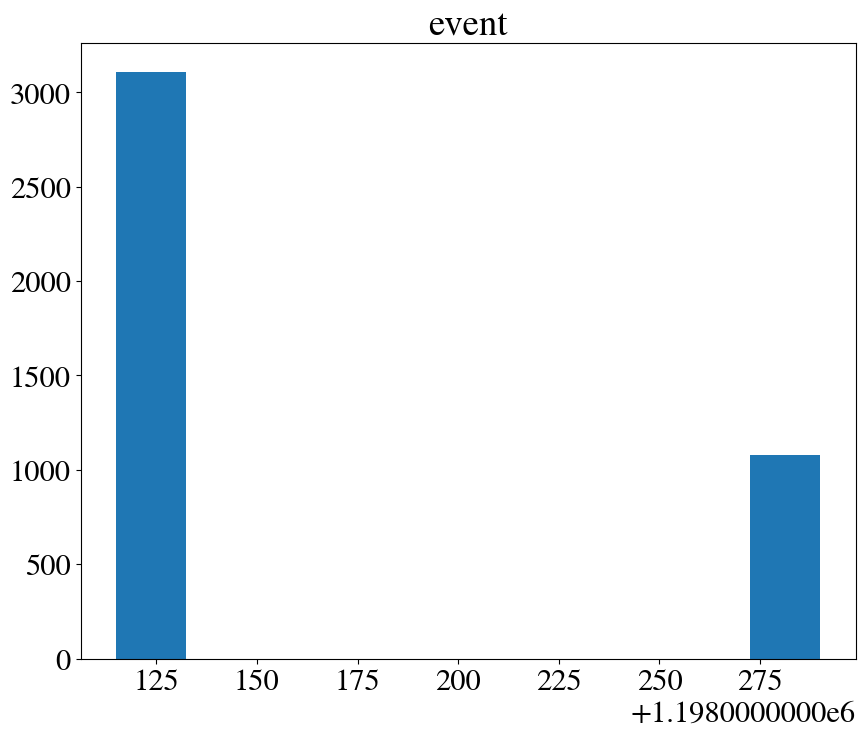

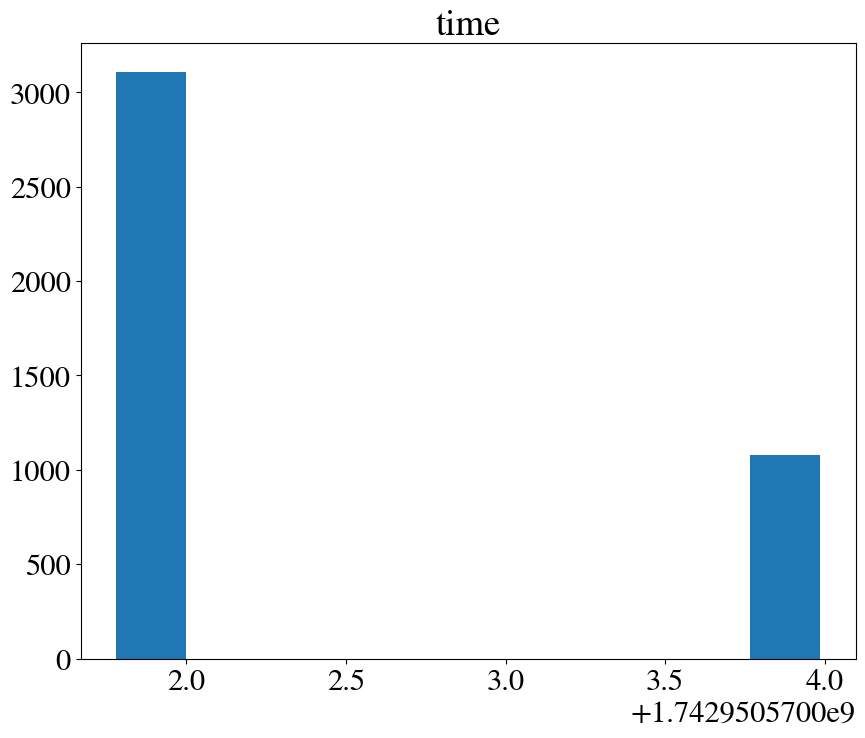

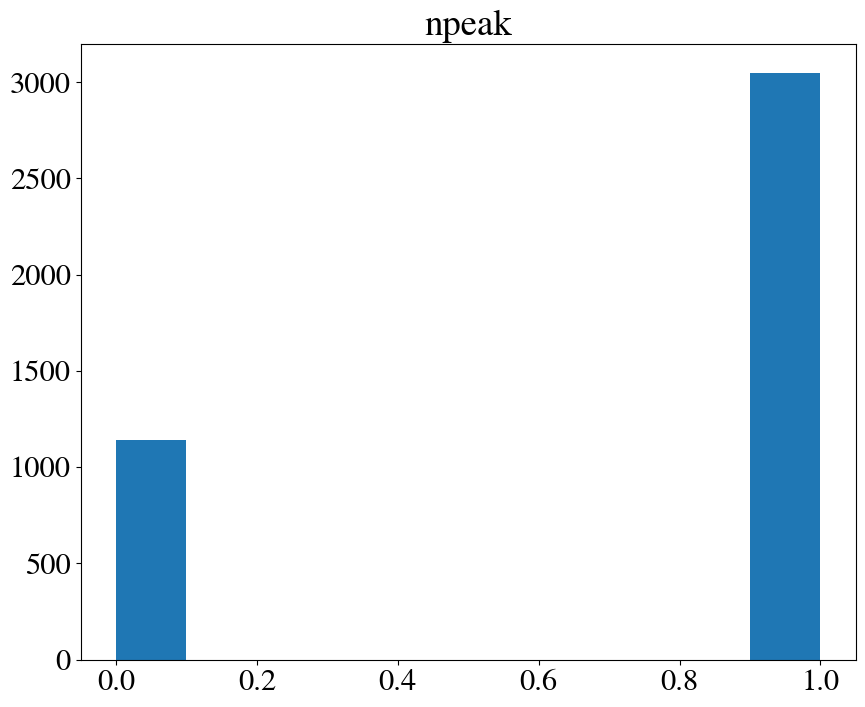

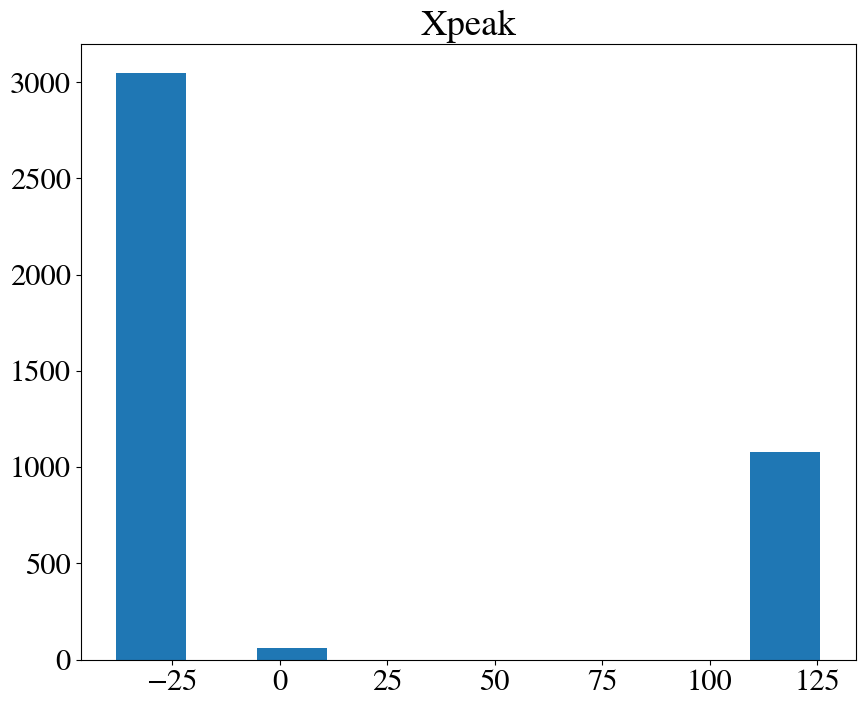

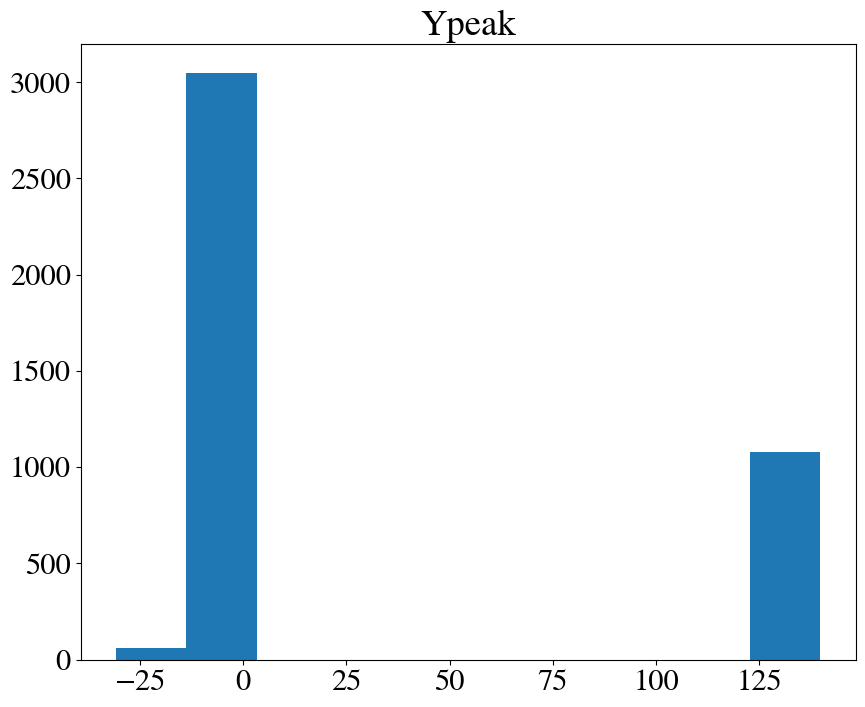

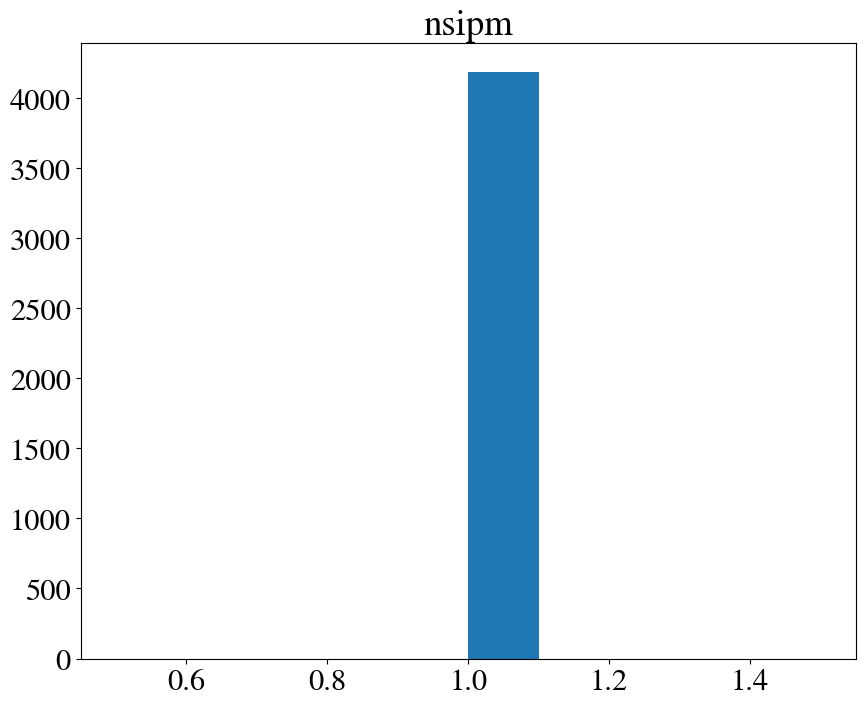

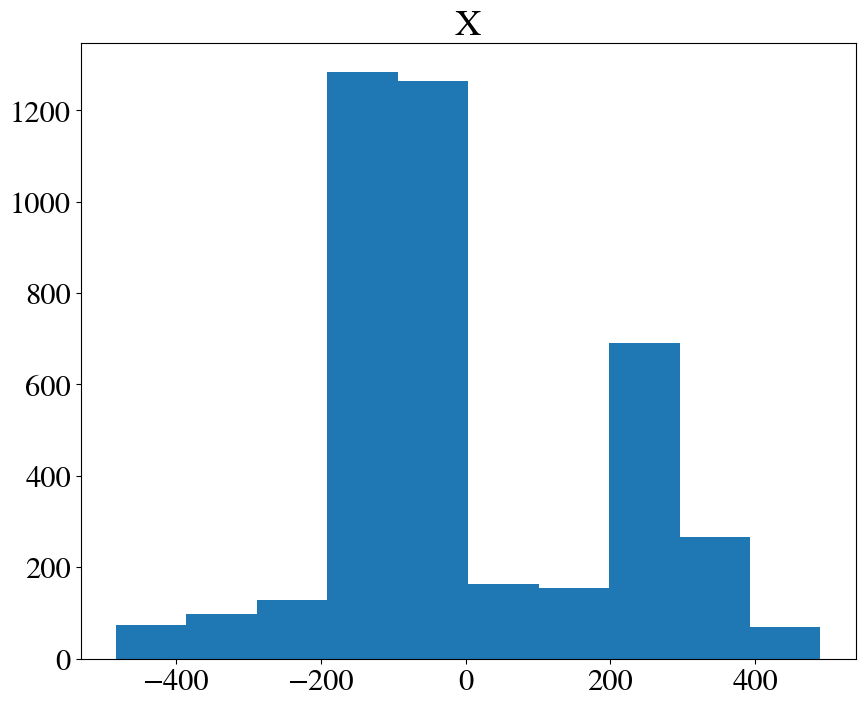

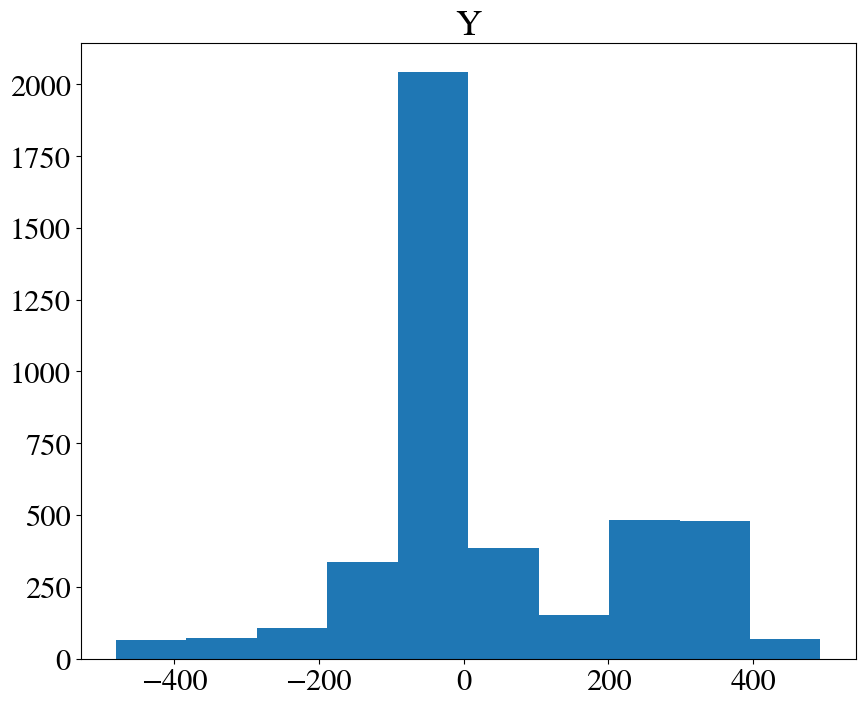

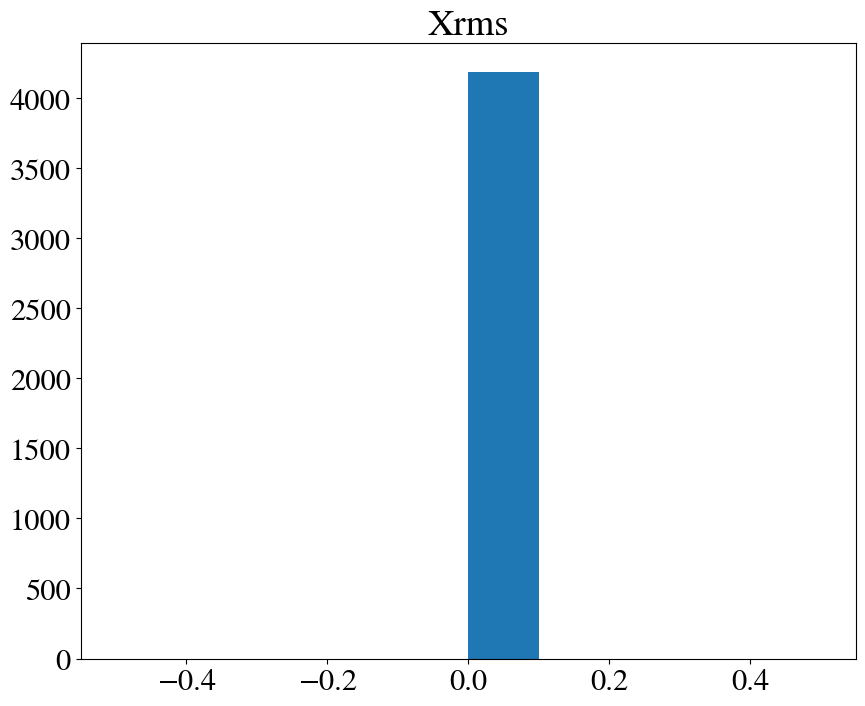

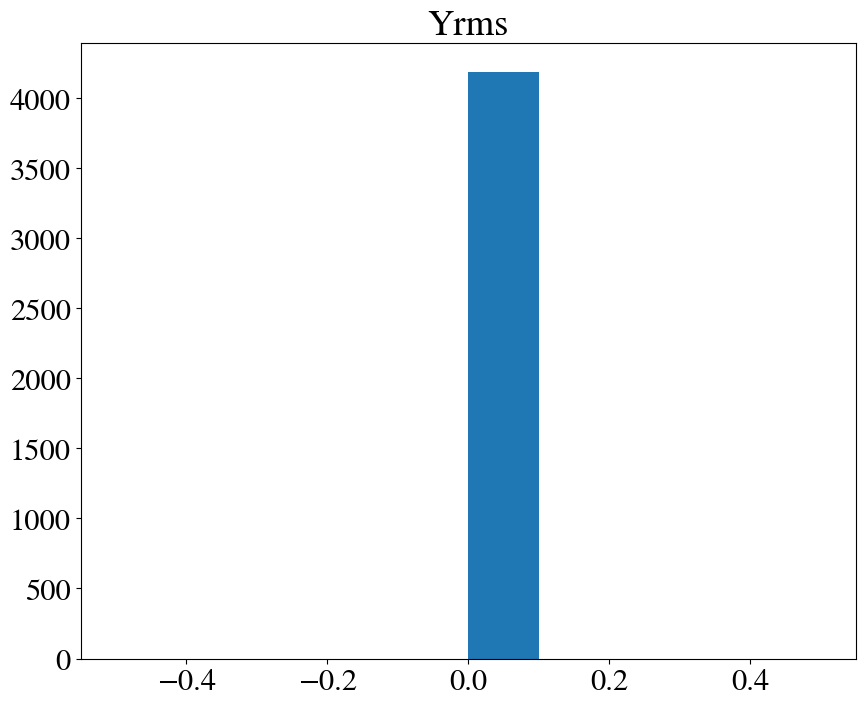

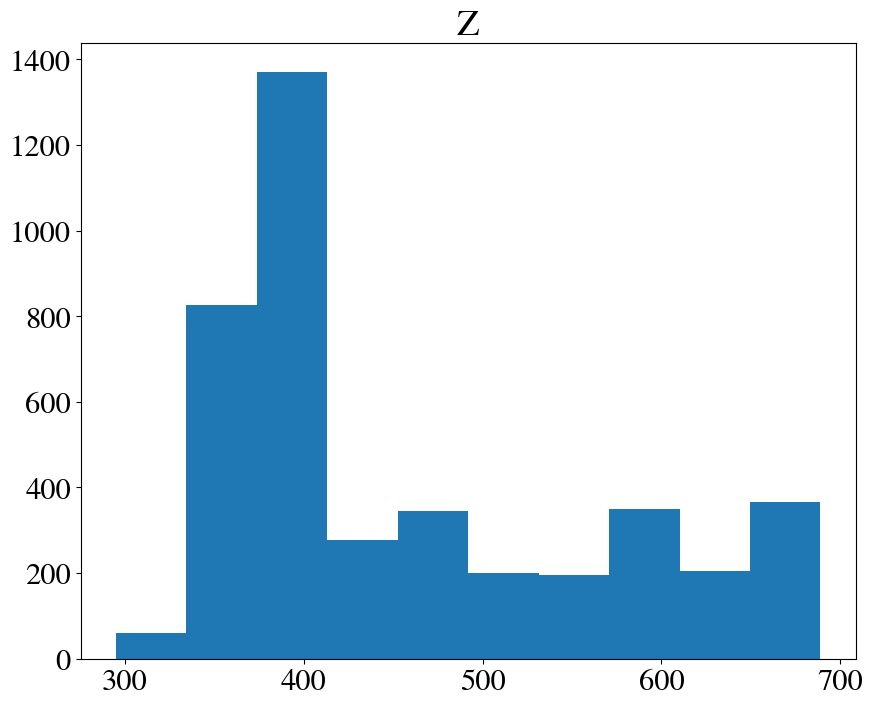

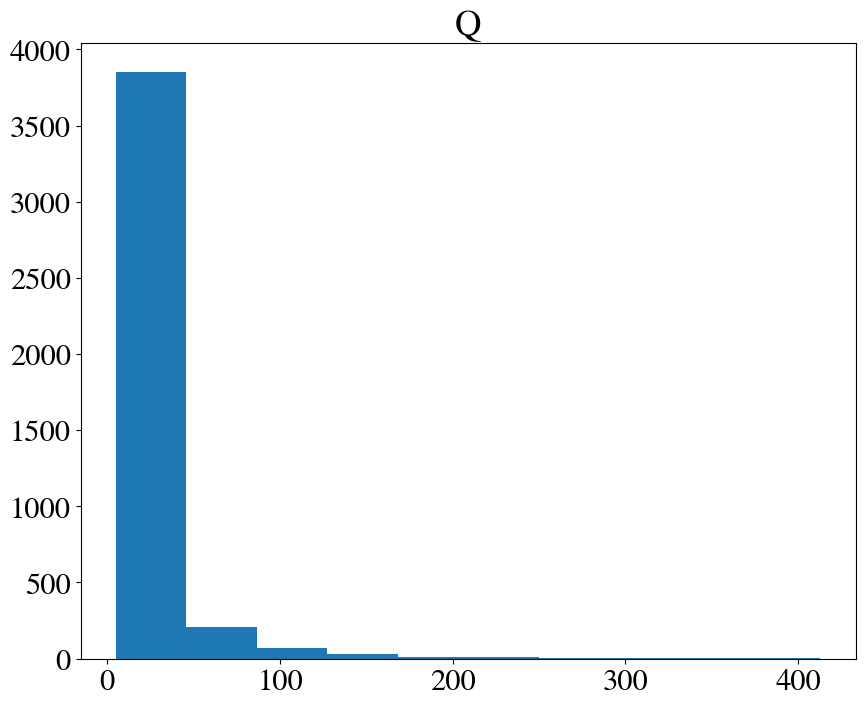

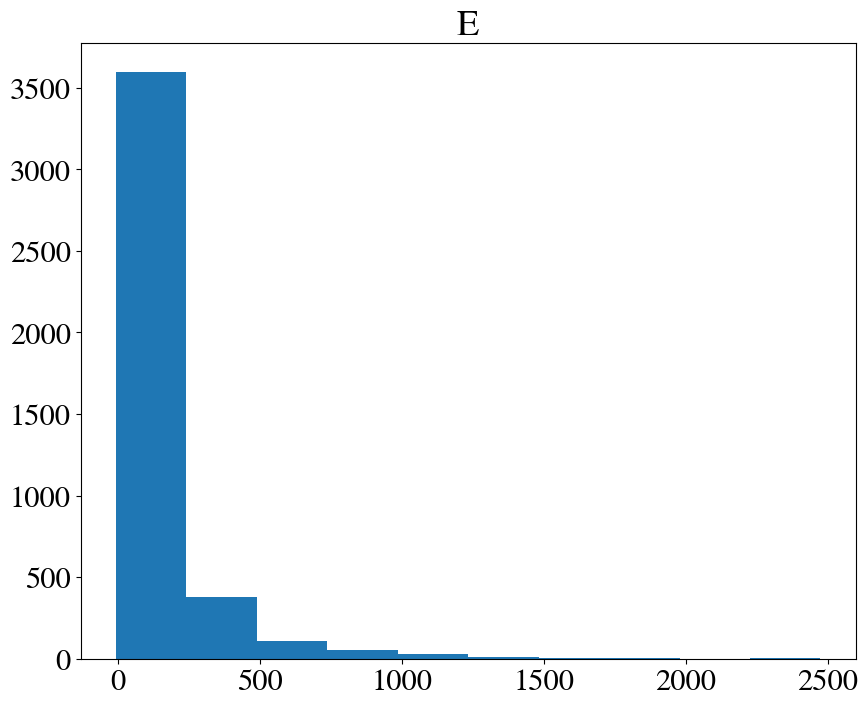

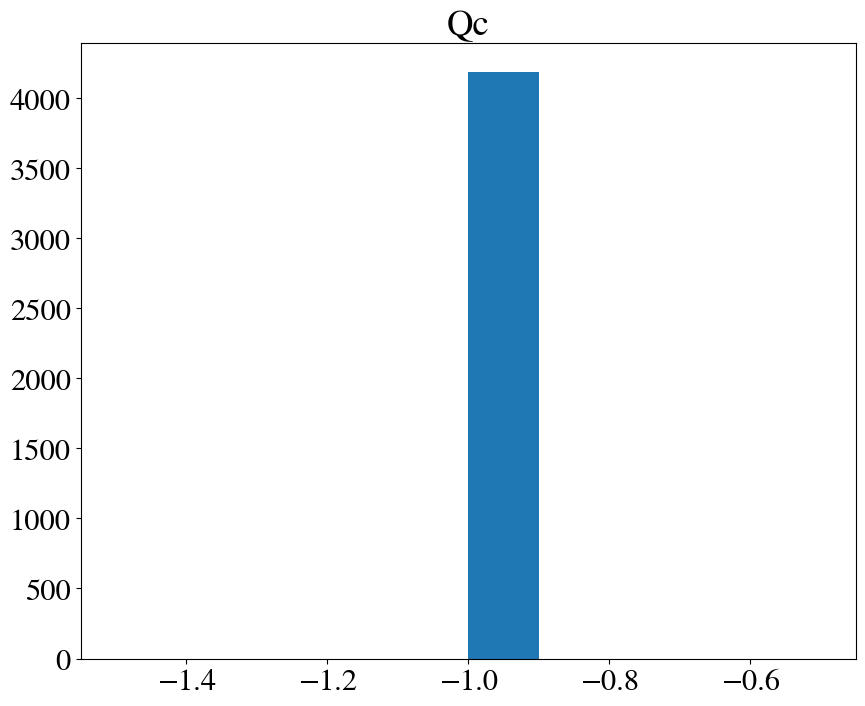

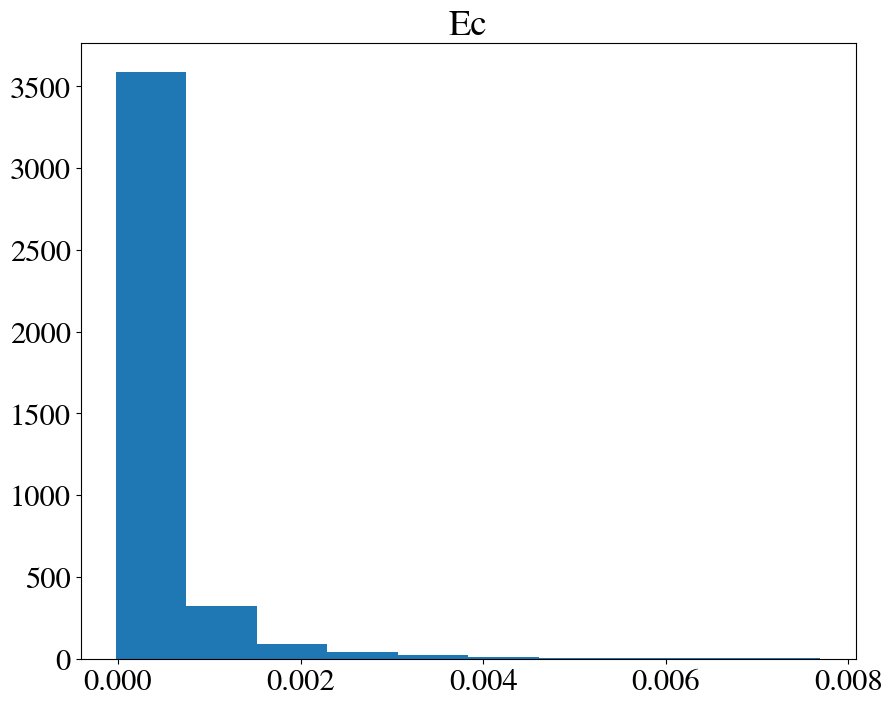

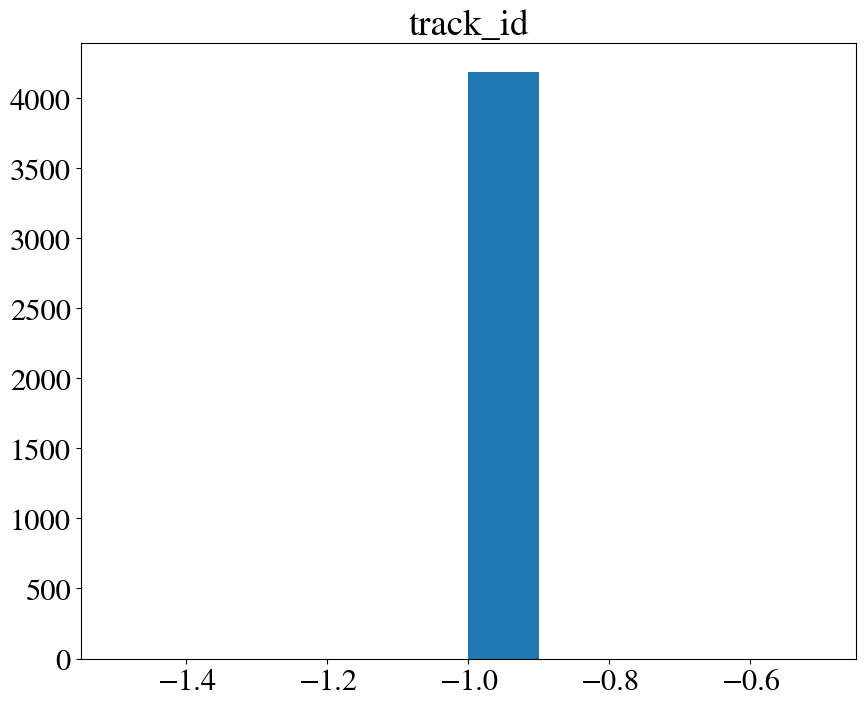

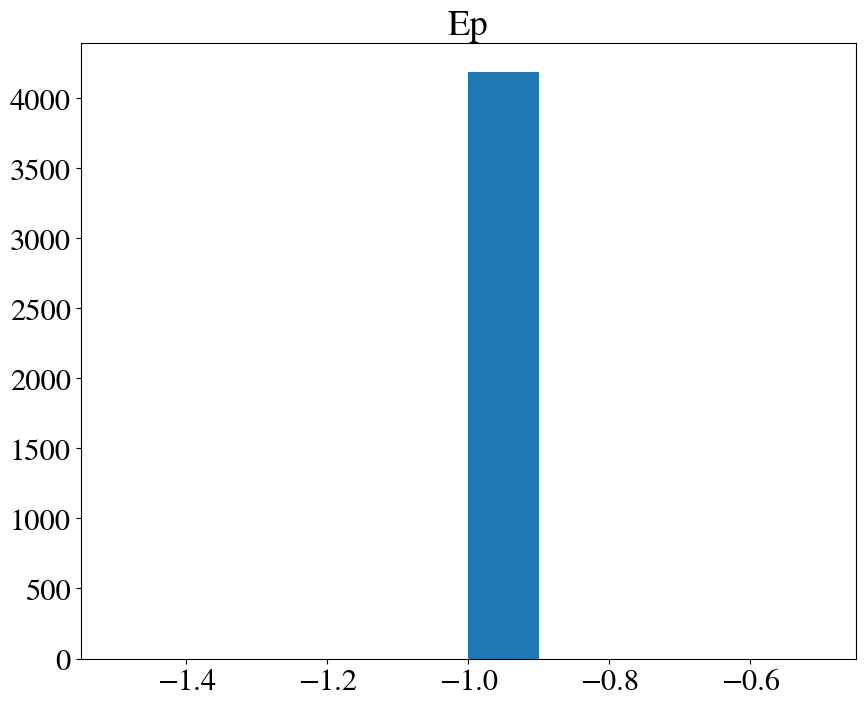

In [ ]:
for cols in .columns.values:
    plt.hist(hits_drop[f'{cols}'].values)
    plt.title(f'{cols}')
    plt.show()

EVENT 1198115
Total energy 1.19 MeV

Time spent in cut_over_Q: 0.03930354118347168 s
Time spent in drop_isolated: 0.09101009368896484 s


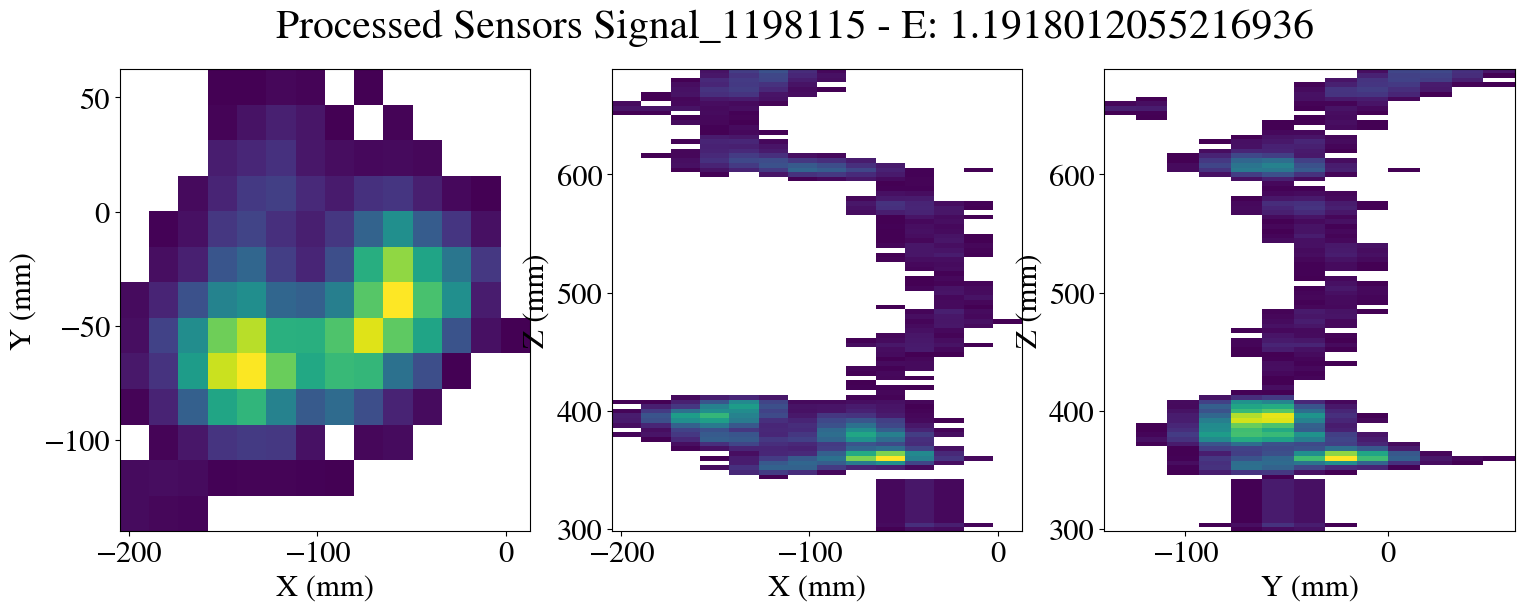

,event,time,npeak,nsipm,X,Y,Xrms,Yrms,Z,track_id,Ep,E,Q,Ec,Qc
0,1198115,1.742951e+09,0,1,-435.975,90.925,0.0,0.0,296.0,-1,-1.0,39.811624,5.009696,0.000125,-1.0
1,1198115,1.742951e+09,0,1,-373.775,153.125,0.0,0.0,304.0,-1,-1.0,32.814855,5.388705,0.000096,-1.0
2,1198115,1.742951e+09,0,1,-265.925,-217.075,0.0,0.0,296.0,-1,-1.0,87.433856,6.652004,0.000244,-1.0
3,1198115,1.742951e+09,0,1,-189.175,-186.475,0.0,0.0,304.0,-1,-1.0,6.286243,6.232829,0.000017,-1.0
4,1198115,1.742951e+09,0,1,-173.625,-294.325,0.0,0.0,296.0,-1,-1.0,45.080528,5.672708,0.000124,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,1198115,1.742951e+09,1,1,474.475,198.775,0.0,0.0,640.0,-1,-1.0,39.707244,5.965560,0.000000,-1.0
2233,1198115,1.742951e+09,1,1,474.475,292.075,0.0,0.0,368.0,-1,-1.0,55.474576,6.798136,0.000000,-1.0
2234,1198115,1.742951e+09,1,1,490.025,-124.775,0.0,0.0,424.0,-1,-1.0,67.870656,5.472364,0.000000,-1.0
2235,1198115,1.742951e+09,1,1,490.025,184.225,0.0,0.0,560.0,-1,-1.0,71.210009,7.838201,0.000000,-1.0


Time spent in cut_over_Q: 0.025159358978271484 s
Time spent in drop_isolated: 0.03826713562011719 s


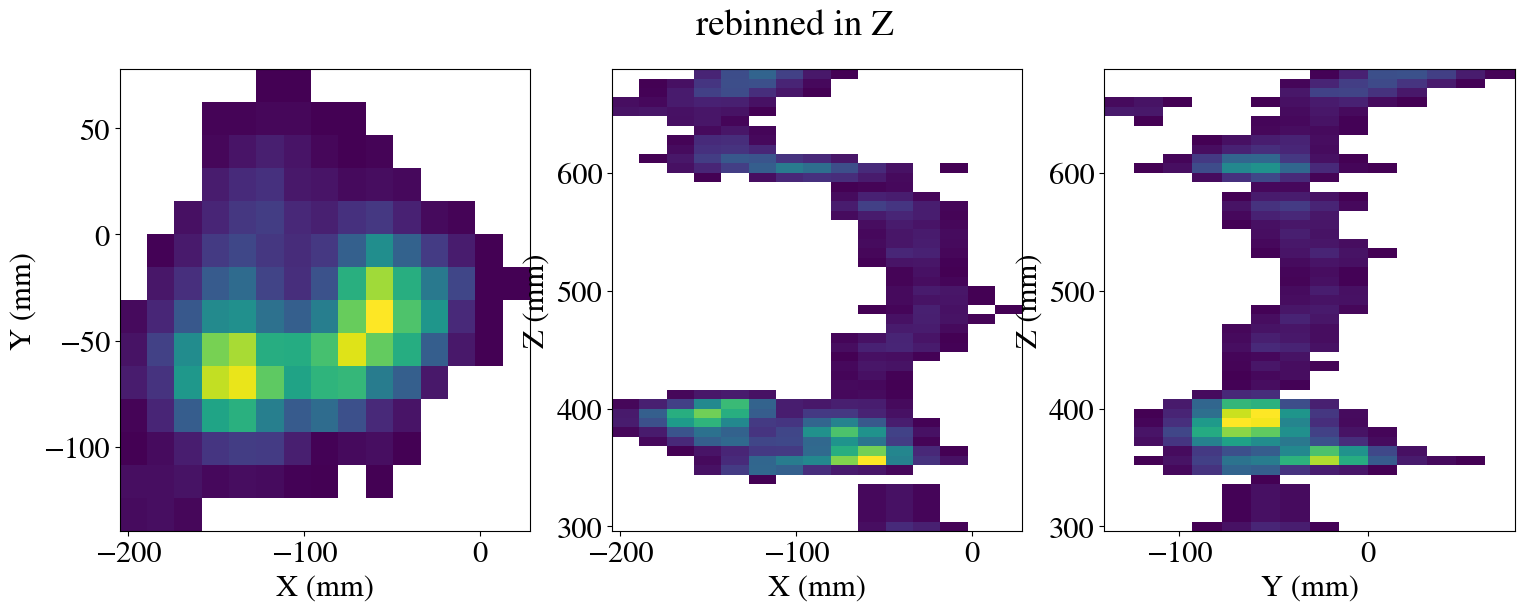

EVENT 1198290
Total energy 0.47 MeV

Time spent in cut_over_Q: 0.012948036193847656 s
Time spent in drop_isolated: 0.015398502349853516 s


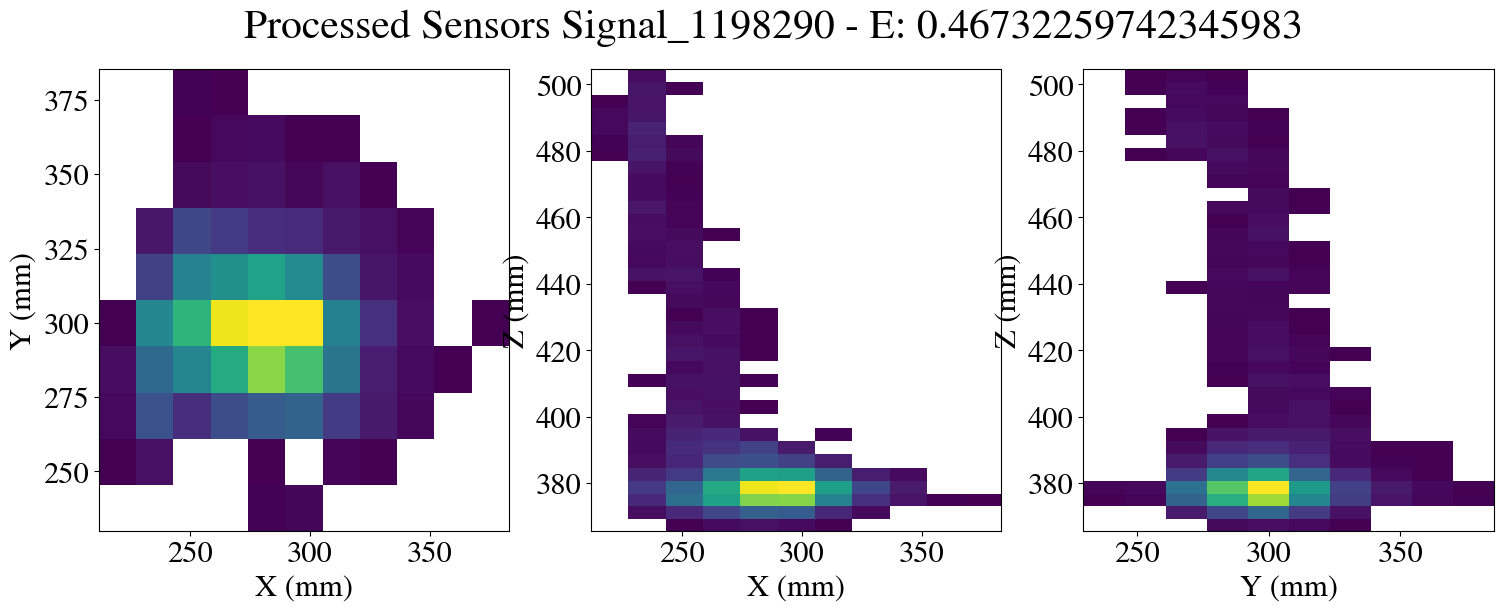

,event,time,npeak,nsipm,X,Y,Xrms,Yrms,Z,track_id,Ep,E,Q,Ec,Qc
0,1198290,1.742951e+09,0,1,-482.625,229.875,0.0,0.0,360.0,-1,-1.0,60.227306,5.182848,0.000000,-1.0
1,1198290,1.742951e+09,0,1,-482.625,260.975,0.0,0.0,432.0,-1,-1.0,42.325793,5.056973,0.000000,-1.0
2,1198290,1.742951e+09,0,1,-467.075,-232.625,0.0,0.0,368.0,-1,-1.0,42.060888,6.395106,0.000000,-1.0
3,1198290,1.742951e+09,0,1,-467.075,-32.475,0.0,0.0,376.0,-1,-1.0,36.739719,6.129526,0.000118,-1.0
4,1198290,1.742951e+09,0,1,-467.075,45.275,0.0,0.0,368.0,-1,-1.0,35.702029,5.428280,0.000116,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,1198290,1.742951e+09,0,1,443.375,260.975,0.0,0.0,408.0,-1,-1.0,71.338919,6.349891,0.000000,-1.0
803,1198290,1.742951e+09,0,1,458.925,-217.075,0.0,0.0,480.0,-1,-1.0,90.500977,8.404390,0.000000,-1.0
804,1198290,1.742951e+09,0,1,458.925,-201.525,0.0,0.0,456.0,-1,-1.0,58.487451,7.056641,0.000000,-1.0
805,1198290,1.742951e+09,0,1,474.475,-32.475,0.0,0.0,488.0,-1,-1.0,55.317906,5.256973,0.000000,-1.0


Time spent in cut_over_Q: 0.012267112731933594 s
Time spent in drop_isolated: 0.013323783874511719 s


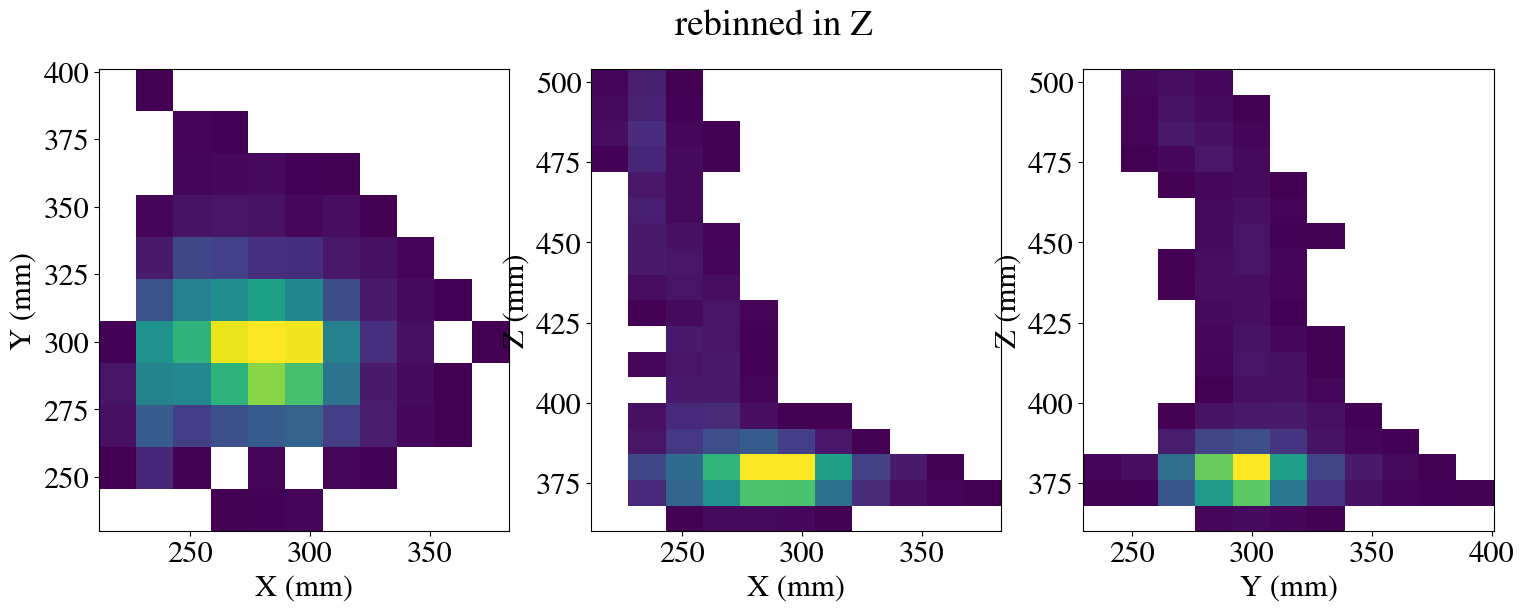

In [21]:
for evts, df in hits_drop.groupby('event'):
    rebin = 8
    zbin = (df.Z // rebin) * rebin # new bin values
    func.plotter(df, evts, cut_sensors=cut_sensors, drop_sensors=drop_sensors)
    df['Z'] = zbin
    q = df.groupby('event time npeak nsipm X Y Xrms Yrms Z track_id Ep'.split()).agg(dict(E="sum", Q="sum", Ec="sum", Qc="sum")).reset_index()
    display(q)
    hits_cut = coref.timefunc(cut_sensors)(q.copy())
    q_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

    func.raw_plotter(q_drop, evts)

In [12]:
'''
for evts, df in hits_drop.groupby('event'):
    display(df)
    print(f'Event: {evts}\nZ values before: {np.sort(df.Z.unique())}\nNumber of Z values: {df.Z.nunique()}')
    # event by event annoyingly
    
    rebin = 10
    zbin = (((df.Z - df.Z.min())) // rebin)*rebin
    print(f"zbin values: {zbin}\nnum of vals {zbin.nunique()}")
    q = df.assign(zbin=zbin).groupby("X Y zbin".split()).agg(dict(Z="mean", E="sum", Q="sum")).reset_index()
    display(q)
    print(f'Z values after: {np.sort(q.Z.unique())}\nNumber of Z values: {q.Z.nunique()}')
    func.raw_plotter(q, evts)
'''


'\nfor evts, df in hits_drop.groupby(\'event\'):\n    display(df)\n    print(f\'Event: {evts}\nZ values before: {np.sort(df.Z.unique())}\nNumber of Z values: {df.Z.nunique()}\')\n    # event by event annoyingly\n    \n    rebin = 10\n    zbin = (((df.Z - df.Z.min())) // rebin)*rebin\n    print(f"zbin values: {zbin}\nnum of vals {zbin.nunique()}")\n    q = df.assign(zbin=zbin).groupby("X Y zbin".split()).agg(dict(Z="mean", E="sum", Q="sum")).reset_index()\n    display(q)\n    print(f\'Z values after: {np.sort(q.Z.unique())}\nNumber of Z values: {q.Z.nunique()}\')\n    func.raw_plotter(q, evts)\n'

In [8]:
# testing
RECO = load_dst('/gluster/data/next/files/TOPOLOGY_John/N100_data/15116/sophronia/trigger2/ldc1/run_15116_0000_ldc1_trg2.v2.3.1.20250312-1-gc1f0fe5.HEDesman.sophronia.h5', 'RECO', 'Events')

In [13]:
for evts, df in RECO.groupby('event'):
    zbin = df.Z // 8
    print(zbin)

0       143.0
1       144.0
2       144.0
3       144.0
4       144.0
        ...  
2022    158.0
2023    159.0
2024    159.0
2025    159.0
2026    159.0
Name: Z, Length: 2027, dtype: float64
2027   -164.0
2028   -163.0
2029   -163.0
2030   -163.0
2031   -163.0
        ...  
3059    181.0
3060    181.0
3061    182.0
3062    182.0
3063    182.0
Name: Z, Length: 1037, dtype: float64
3064   -140.0
3065   -139.0
3066   -139.0
3067   -139.0
3068   -138.0
        ...  
5595    179.0
5596    179.0
5597    179.0
5598    180.0
5599    180.0
Name: Z, Length: 2536, dtype: float64
5600   -124.0
5601   -124.0
5602   -124.0
5603   -124.0
5604   -123.0
        ...  
7382    211.0
7383    211.0
7384    212.0
7385    212.0
7386    212.0
Name: Z, Length: 1787, dtype: float64
7387     95.0
7388     95.0
7389     95.0
7390     96.0
7391     96.0
        ...  
9848    184.0
9849    184.0
9850    184.0
9851    184.0
9852    184.0
Name: Z, Length: 2466, dtype: float64
9853     -83.0
9854     -83.0
9855     -